<div style="color:#00BFFF">

# Nowcasting Consumer Expenditure: 

### Further Analysis for fitting data to model

<div style="color:#00BFFF">

##### Introduction:  Uncovering Reliable Proxies for Consumer Spending Behaviour. 

<div style="color:#00BFFF">

##### Setup Environment and import libraries

In [1]:
# ------- Standard Library Imports -------
import warnings
from datetime import datetime

# ------- Third-Party Library Imports -------
import pandas as pd
from pandas import NaT
import numpy as np
import missingno as msno

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Remove warnings
warnings.filterwarnings('ignore')

# Set the display options
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

/var/folders/30/bhymp02j1fb47cmvs80_1b4m0000gn/T/ipykernel_35252/1615628173.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#load data generated from [2]M1_Exploratory_Data_analytics.ipynb

#open final_proxy_dataset.csv
final_proxy_dataset = pd.read_csv('./results/final_dataset/final_proxy_dataset.csv', index_col=0,parse_dates=False)

In [3]:
refined_datset = final_proxy_dataset.copy()
refined_datset.tail(2)

,1-Year Treasury Rate,6-Month Treasury Bill:,All Employees: Construction,All Employees: Durable goods,All Employees: Financial Activities,All Employees: Goods-Producing Industries,All Employees: Government,All Employees: Manufacturing,All Employees: Nondurable goods,All Employees: Retail Trade,All Employees: Service-Providing Industries,All Employees: Total nonfarm,"All Employees: Trade, Transportation & Utilities",All Employees: Wholesale Trade,Capacity Utilization: Manufacturing,Civilian Employment,Civilian Unemployment Rate,Civilians Unemployed for 5-14 Weeks,IP Index,IP: Business Equipment,IP: Durable Materials,IP: Final Products (Market Group),IP: Final Products and Nonindustrial Supplies,IP: Manufacturing (SIC),IP: Materials,M1 Money Stock,M2 Money Stock,Real M2 Money Stock,Real Manu. and Trade Industries Sales,Real personal consumption expenditures,Retail and Food Services Sales,PCE
202303,0.56,0.42,NaN,0.406981,NaN,0.376019,0.367151,0.069335,-0.492612,-0.024473,0.388879,0.387101,-0.058908,-0.008268,-0.2416,0.111861,0.1,4.703495,-0.350314,0.745441,2.045578,-0.608550,-0.648985,0.015543,0.012144,2.159999,2.180983,-0.775006,0.667410,0.527783,1.289197,0.814426
202306,0.20,0.12,NaN,0.270403,NaN,0.282244,0.901085,0.053894,-0.309119,0.054090,0.446608,0.423896,0.079691,0.552428,0.1685,0.338548,0.2,9.923368,1.006064,-0.185058,0.253593,0.950138,0.813045,0.542988,1.299016,0.656451,-0.373288,-1.667477,1.243294,0.775768,2.118687,1.404393


<div style="color:#00BFFF">

##### Implementation of Principal Component Regression (PCR) Analysis


To enhance our predictive models, we employ Principal Component Regression (PCR) analysis. This methodology combines Principal Component Analysis (PCA) with Linear Regression, addressing issues of multicollinearity among predictors while leveraging dimensionality reduction to improve model performance.

Through the application of PCR analysis, this project aims to offer timely insights into consumer spending, addressing the existing gaps in economic data reporting. The predictive model and its visual representation through the fan chart illustrate our methodology's potential to inform more responsive economic decision-making.

In [4]:
# Check for missing values in the new dataset
missing_values_summary = final_proxy_dataset.isnull().sum()

# Display the number of missing values for each column if any
missing_values_summary[missing_values_summary > 0]


All Employees: Construction            12
All Employees: Financial Activities    12
dtype: int64

In [5]:
#ffill and bfill missing values
final_proxy_dataset.fillna(method='ffill', inplace=True)
final_proxy_dataset.fillna(method='bfill', inplace=True)

# # Visualize missing values
# msno.matrix(refined_datset)

In [6]:
# 'final_proxy_dataset' index is in 'YYYYMM' string format
final_proxy_dataset.index = pd.to_datetime(final_proxy_dataset.index, format='%Y%m')

final_proxy_dataset.tail()

,1-Year Treasury Rate,6-Month Treasury Bill:,All Employees: Construction,All Employees: Durable goods,All Employees: Financial Activities,All Employees: Goods-Producing Industries,All Employees: Government,All Employees: Manufacturing,All Employees: Nondurable goods,All Employees: Retail Trade,All Employees: Service-Providing Industries,All Employees: Total nonfarm,"All Employees: Trade, Transportation & Utilities",All Employees: Wholesale Trade,Capacity Utilization: Manufacturing,Civilian Employment,Civilian Unemployment Rate,Civilians Unemployed for 5-14 Weeks,IP Index,IP: Business Equipment,IP: Durable Materials,IP: Final Products (Market Group),IP: Final Products and Nonindustrial Supplies,IP: Manufacturing (SIC),IP: Materials,M1 Money Stock,M2 Money Stock,Real M2 Money Stock,Real Manu. and Trade Industries Sales,Real personal consumption expenditures,Retail and Food Services Sales,PCE
2022-06-01,1.24,1.52,1.388411,0.975862,0.668862,0.715264,0.572757,0.761583,0.410257,0.226028,0.848286,0.829815,0.393352,0.626563,0.3200,0.490837,-0.1,5.262704,0.816630,2.149355,1.371123,0.564030,0.508764,0.661687,1.148606,-1.321337,-0.506709,-1.264904,1.888560,0.733035,-0.340469,1.533394
2022-09-01,0.79,0.92,1.388411,0.793655,0.668862,0.626346,0.421828,0.440308,-0.143399,-0.158166,0.541766,0.553508,-0.059078,0.415538,-2.3779,0.255190,0.0,1.593171,-1.993597,-2.380810,-2.722339,-0.820252,-1.292597,-2.736535,-2.782494,-0.696709,-0.125014,-1.601167,0.546969,-0.099006,-0.868696,1.307840
2022-12-01,0.00,0.22,1.388411,-0.049419,0.668862,0.186211,1.042419,0.015414,0.122926,0.331538,0.671799,0.604504,0.347018,0.316312,0.6711,0.952138,0.0,7.041031,1.150573,-0.558715,0.127426,-0.107414,0.098625,1.185731,2.366223,-2.260271,-1.506098,-3.222070,-1.139060,0.877987,1.379186,1.948849
2023-03-01,0.56,0.42,1.388411,0.406981,0.668862,0.376019,0.367151,0.069335,-0.492612,-0.024473,0.388879,0.387101,-0.058908,-0.008268,-0.2416,0.111861,0.1,4.703495,-0.350314,0.745441,2.045578,-0.608550,-0.648985,0.015543,0.012144,2.159999,2.180983,-0.775006,0.667410,0.527783,1.289197,0.814426
2023-06-01,0.20,0.12,1.388411,0.270403,0.668862,0.282244,0.901085,0.053894,-0.309119,0.054090,0.446608,0.423896,0.079691,0.552428,0.1685,0.338548,0.2,9.923368,1.006064,-0.185058,0.253593,0.950138,0.813045,0.542988,1.299016,0.656451,-0.373288,-1.667477,1.243294,0.775768,2.118687,1.404393



<div style="color:#00BFFF">

##### Data Preparation


The first step involves preparing the dataset for analysis. We split the data based on a specified cutoff date, separating it into training and testing sets. This separation allows us to simulate a realistic forecasting scenario, where the model is trained on historical data and tested on unseen, future data.

```python
X_train, y_train, X_test, C, df_train, df_test = prepare_data(final_proxy_dataset, '2010-12')
```

In [7]:
def prepare_data(final_proxy_dataset, cutoff_date='2022-12', format='%Y-%m'):
    """
    Prepares the dataset for training and testing.
    """
    # Convert string dates to datetime format for comparison
    cutoff_date_dt = pd.to_datetime(cutoff_date, format=format)
    
    # Splitting the dataset based on the cutoff date
    df_train = final_proxy_dataset[final_proxy_dataset.index < cutoff_date_dt]
    df_test = final_proxy_dataset[final_proxy_dataset.index >= cutoff_date_dt]
    
    # Separate predictors and target
    X_train = df_train.drop(columns=['PCE'])
    y_train = df_train['PCE']
    X_test = df_test.drop(columns=['PCE'])
    C = df_test['PCE']
    
    return X_train, y_train, X_test, C, df_train, df_test



<div style="color:#00BFFF">

##### Model Training and Prediction



We then proceed to train our PCR model. The process integrates data standardization, PCA for dimensionality reduction, and linear regression for prediction. This pipeline ensures that the model captures the essential dynamics of the data while mitigating the risk of overfitting.

```python
pipeline, predicted_pce = train_and_predict(X_train, y_train, X_test, n_components=5)
```

In [8]:
def train_and_predict(X_train, y_train, X_test,n_components=3):
    """
    Trains the model and makes predictions.
    """
    # Creating pipeline
    pipeline = make_pipeline(StandardScaler(), PCA(n_components), LinearRegression())
    
    # Fitting the model to the training data
    pipeline.fit(X_train, y_train)
    
    # Making predictions
    predicted_pce = pipeline.predict(X_test)
    
    return pipeline, predicted_pce





<div style="color:#00BFFF">

##### Visualization with a Fan Chart


Finally, we visualize the actual versus predicted Personal Consumption Expenditures (PCE) using a fan chart. This chart starts from a specified date, showcasing the model's predictions and associated uncertainties. The visualization underscores the model's performance and highlights the predictive uncertainty, providing a comprehensive view of the forecast's reliability.

```python
plot_fan_chart(df_train, C, predicted_pce, X_train, y_train, start_date='2007-03-01')
```

In [9]:
def plot_fan_chart(df_train, C, predicted_pce, X_train, y_train, start_date='2020-03-01'):
    """
    Creates a fan chart to visualize actual vs. predicted PCE with uncertainty, starting from a specified date.
    
    Args:
    - df_train: DataFrame containing the training data.
    - C: Series containing the test targets.
    - predicted_pce: The predicted PCE values for the test set.
    - cutoff_date: The cutoff date used to split the data (for reference).
    - start_date: The start date for the chart to display the data from.
    - format: The format of the cutoff_date and start_date strings.
    """
    # Ensure the indices are aligned by reindexing if necessary
    combined_actual_pce = pd.concat([df_train['PCE'], C]).sort_index()
    
    # Filter the combined_actual_pce to start from the specified start_date
    start_date_dt = pd.to_datetime(start_date, format='%Y-%m-%d')
    combined_actual_pce = combined_actual_pce[combined_actual_pce.index >= start_date_dt]
    
    # Prepare dates for plotting, ensuring they match the filtered combined_actual_pce index
    dates_for_plotting = combined_actual_pce.index

    # Recalculate residuals and prediction uncertainty based on the filtered data
    pipeline, _ = train_and_predict(X_train, y_train, X_train) 
    y_train_pred = pipeline.predict(X_train.loc[df_train.index >= start_date_dt])
    residuals = y_train.loc[df_train.index >= start_date_dt] - y_train_pred
    prediction_uncertainty_std = np.std(residuals)
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates_for_plotting, combined_actual_pce, 'green', label='Actual PCE')
    plt.plot(dates_for_plotting[-len(predicted_pce):], predicted_pce, 'b--', label='Predicted PCE')
    
    prediction_dates = dates_for_plotting[-len(predicted_pce):]

    for std_dev, color in zip([1, 2], ['skyblue', 'lightsteelblue']):
        plt.fill_between(prediction_dates, 
                         predicted_pce - prediction_uncertainty_std * std_dev, 
                         predicted_pce + prediction_uncertainty_std * std_dev, 
                         color=color, alpha=0.5, label=f'±{std_dev} STD')

    plt.title('Fan Chart: Actual vs. Predicted PCE with Uncertainty')
    plt.xlabel('Date')
    plt.ylabel('PCE')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()



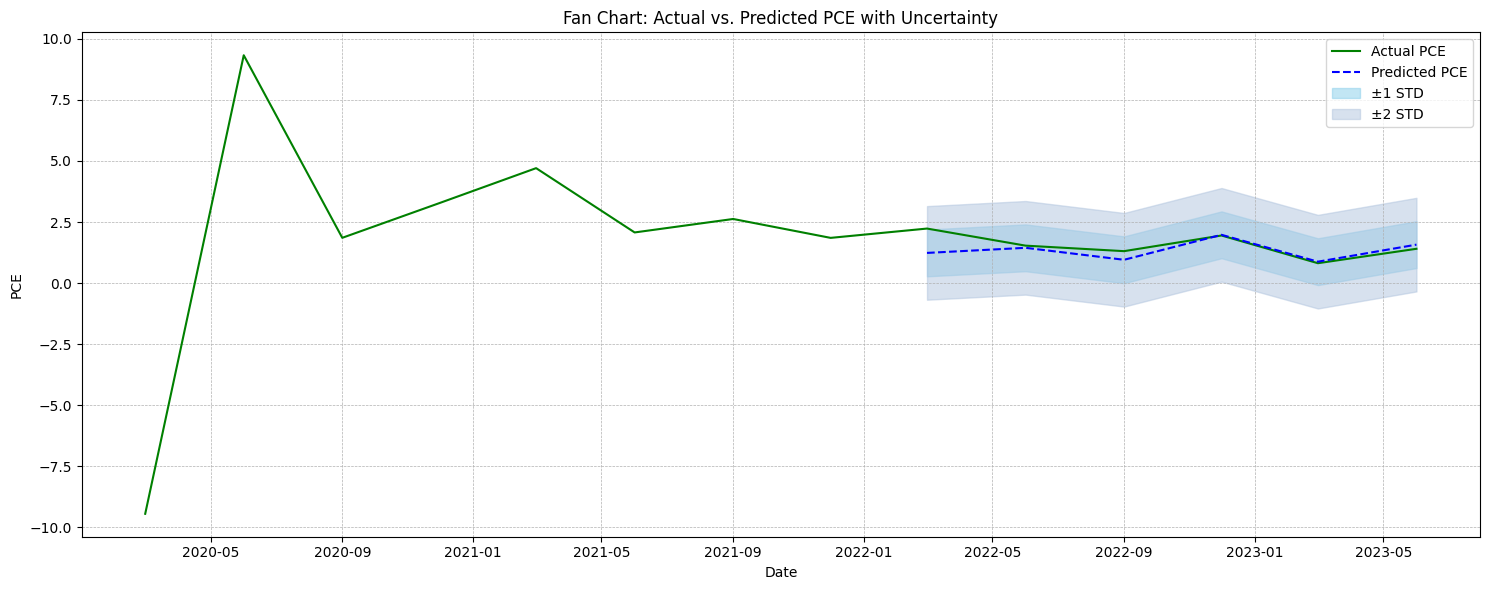

In [10]:

# Prepare the data
X_train, y_train, X_test, C, df_train, df_test = prepare_data(final_proxy_dataset, '2022-03')

# Train the model and make predictions
pipeline, predicted_pce = train_and_predict(X_train, y_train, X_test,n_components=5)

# Plot the fan chart
plot_fan_chart(df_train, C, predicted_pce, X_train, y_train, start_date='2020-03-01')



<div style="color:#00BFFF">

##### PCA Analysis : Interpretation of Results

Our Principal Component Regression (PCR) analysis focused on predicting Personal Consumption Expenditures (PCE), aiming to provide insights into consumer spending behavior, especially during the rapidly changing economic landscape influenced by the COVID-19 pandemic. The primary goal was to leverage high-frequency data proxies to forecast PCE more timely than traditional economic reports.

In [11]:
predicted_pce

array([1.23556452, 1.44429318, 0.95437606, 1.97632823, 0.87669727,
       1.57426045])

<div style="color:#00BFFF">

##### Predicted PCE


</div>

The PCR model generated predictions for future PCE values as follows:

```
[1.23556452, 1.44429318, 0.95437606, 1.97632823, 0.87669727, 1.57426045]
```

These predictions fall within a range that reflects normal consumer spending behavior, especially when compared to the extreme values observed during COVID-19, where the scale reached between -10 and 10. For the majority of the timeline, the model's predictions suggest a stabilized consumer spending pattern, with values ranging between 1 and 5.


In [12]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(C, predicted_pce)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(C, predicted_pce, squared=False)  # Set squared=False for RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.28320159640624737
Root Mean Squared Error (RMSE): 0.4397778155206625



##### Model Performance

The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) provide insights into the model's accuracy:

- **Mean Absolute Error (MAE): 0.2832** suggests that, on average, the model's predictions are approximately 0.2832 units away from the actual PCE values. Given the scale of our data, this level of MAE indicates a relatively high accuracy in the model's predictions.
- **Root Mean Squared Error (RMSE): 0.4398** also reflects the model's prediction accuracy, accounting for the square root of the average squared differences between predicted and actual values. The relatively low RMSE further confirms the model's effectiveness in capturing the underlying trends in consumer spending.



<div style="color:#00BFFF">

##### Principal Component Analysis (PCA)

</div>

The PCA performed as part of the PCR process aimed to address multicollinearity among predictors and reduce dimensionality to enhance model performance. The factor loadings heatmap and the scree plot provide insights into the PCA results:

- **Factor Loadings Heatmap**: The heatmap visualization of the first three principal components' factor loadings on various indicators reveals which variables most influence each principal component. This insight helps understand the underlying dimensions of consumer spending behavior captured by the model.

- **Scree Plot**: The scree plot, showing the variance explained by each principal component, illustrates that a significant portion of the variance in the data can be captured by the first few components. This reduction not only simplifies the model but also focuses on the most influential factors driving PCE.


In [13]:
# Performing PCA on the standardized predictors from the training dataset up to the end of 2022
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Fitting PCA
pca = PCA()
pca.fit(X_scaled)

# Extracting factor loadings (the PCA components)
factor_loadings = pca.components_

# Mapping factor loadings to original variable names
factor_loadings_df = pd.DataFrame(factor_loadings, columns=X_train.columns, index=[f'PC{i+1}' for i in range(factor_loadings.shape[0])])

# Displaying factor loadings for the first few principal components for brevity
factor_loadings_df.head()

# Extracting factor loadings (the PCA components)
factor_loadings = pca.components_

# Mapping factor loadings to original variable names
factor_loadings_df = pd.DataFrame(factor_loadings, columns=X_train.columns, index=[f'PC{i+1}' for i in range(factor_loadings.shape[0])])

# Displaying factor loadings for the first few principal components for brevity
factor_loadings_df.head()

,1-Year Treasury Rate,6-Month Treasury Bill:,All Employees: Construction,All Employees: Durable goods,All Employees: Financial Activities,All Employees: Goods-Producing Industries,All Employees: Government,All Employees: Manufacturing,All Employees: Nondurable goods,All Employees: Retail Trade,All Employees: Service-Providing Industries,All Employees: Total nonfarm,"All Employees: Trade, Transportation & Utilities",All Employees: Wholesale Trade,Capacity Utilization: Manufacturing,Civilian Employment,Civilian Unemployment Rate,Civilians Unemployed for 5-14 Weeks,IP Index,IP: Business Equipment,IP: Durable Materials,IP: Final Products (Market Group),IP: Final Products and Nonindustrial Supplies,IP: Manufacturing (SIC),IP: Materials,M1 Money Stock,M2 Money Stock,Real M2 Money Stock,Real Manu. and Trade Industries Sales,Real personal consumption expenditures,Retail and Food Services Sales
PC1,-0.094656,-0.096581,-0.171328,-0.205794,-0.151438,-0.209354,-0.131129,-0.210385,-0.197143,-0.210052,-0.206311,-0.219199,-0.221888,-0.207445,-0.193743,-0.209300,0.213964,0.178019,-0.210885,-0.185260,-0.191318,-0.187530,-0.204372,-0.206781,-0.201017,0.149645,0.129944,0.137222,-0.119514,-0.084731,-0.045133
PC2,0.176044,0.179192,0.024123,0.041851,-0.064645,0.018628,-0.290669,0.014943,-0.059193,-0.123583,-0.227781,-0.185885,-0.121555,-0.082962,0.193428,-0.164385,0.170147,0.225236,0.165073,0.175885,0.195683,0.217666,0.194080,0.196786,0.120648,0.264463,0.171805,0.140517,0.316827,0.209220,0.276007
PC3,-0.121359,-0.127053,-0.299738,-0.292768,-0.212554,-0.308709,0.152958,-0.275283,-0.195635,0.008063,0.030760,-0.037241,-0.076882,-0.206436,0.124962,0.041555,-0.052563,-0.218813,0.117805,0.051655,0.078630,0.120093,0.101678,0.114402,0.125443,-0.301482,-0.352459,-0.077447,0.120707,0.249443,0.150038
PC4,-0.496617,-0.493401,0.223312,-0.022562,0.296813,0.041504,0.046043,-0.011502,0.018170,0.099995,0.051670,0.038444,0.071953,0.018958,-0.082103,0.015037,0.017046,0.036308,-0.048755,0.018453,-0.056256,0.026889,0.024847,-0.019871,-0.104802,0.045808,0.173345,0.258240,0.153915,0.355929,0.266601
PC5,0.363379,0.353430,0.141838,-0.054787,0.051585,0.004991,0.052497,-0.041796,0.000322,0.093387,0.049146,0.042712,0.080476,0.020241,-0.116742,0.072708,-0.036476,-0.031137,-0.207837,-0.230093,-0.130303,-0.207942,-0.170059,-0.145783,-0.227062,-0.047653,-0.151905,-0.041173,0.164757,0.377943,0.465358


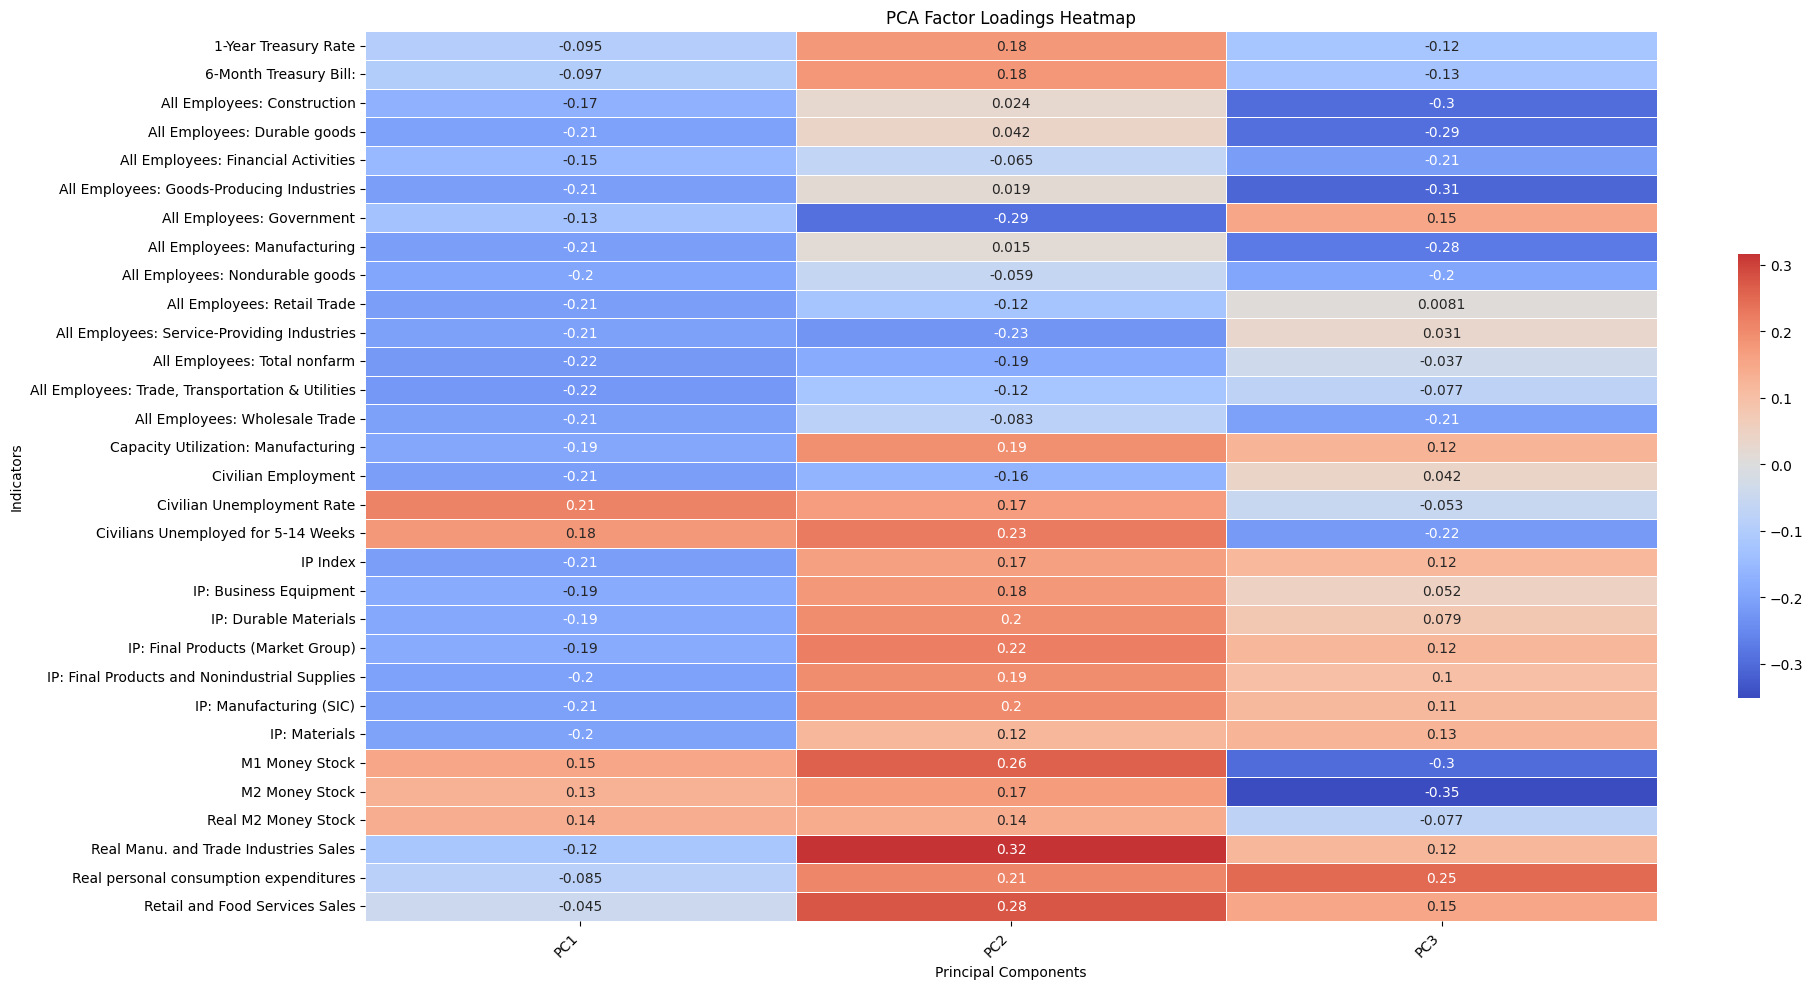

In [14]:
# Assuming factor_loadings_df is your DataFrame and you're focusing on the first 5 PCs
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(factor_loadings_df.iloc[:3, :].transpose(), annot=True, cmap='coolwarm', center=0,
                      linewidths=.5, cbar_kws={"shrink": .5})
heatmap.set_title('PCA Factor Loadings Heatmap')
heatmap.set_xlabel('Principal Components')
heatmap.set_ylabel('Indicators')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

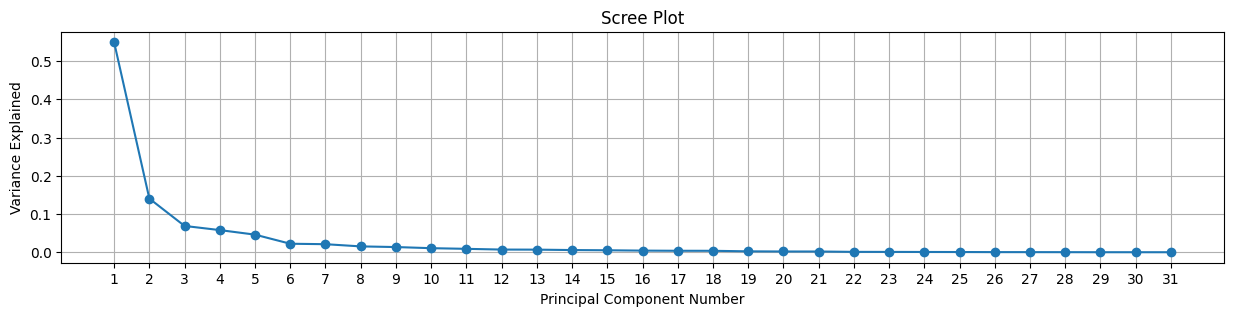

In [15]:
# # Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Scree Plot from the PCA performed earlier
plt.figure(figsize=(15, 3))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

plt.show()



##### Economic Implications

The model's predictions, grounded in high-frequency data proxies, offer a near-real-time view of consumer spending. This capability is particularly valuable for policymakers and market analysts seeking to make informed decisions amidst rapidly changing economic conditions. The use of PCR, complemented by PCA, demonstrates a sophisticated approach to economic forecasting that can adapt to the complexities of modern economic dynamics.

##### Conclusion

The PCR model's ability to predict PCE accurately, as evidenced by the low MAE and RMSE, coupled with the insights gained from PCA, positions this approach as a potent tool in economic data analysis. By identifying and validating high-frequency data proxies, this project contributes to the ongoing effort to enhance the timeliness and relevance of economic indicators, ultimately supporting more agile and informed economic decision-making processes.